# Probability Analysis 

## Explanation

This initial section sets up the **Python environment** and imports the necessary libraries.

### **Standard Libraries**
The following libraries are used for basic operations, numerical processing, and visualization:
- `os` – Handles file system operations.
- `numpy` – Provides numerical processing capabilities.
- `datetime` – Manages time-related data.
- `sys` – Enables system-specific operations.
- `matplotlib.pyplot` – Creates visualizations.

### **Custom Modules**
Several custom modules are utilized for specialized tasks:

- **`analysis`** – Core functions for evacuation analysis and safe zone identification.
- **`data_utils`** – Utilities for reading geographic data.
- **`raster_utils`** – Functions for processing raster (geospatial) data.
- **`visualization`** – Functions for creating visual outputs.
- **`graph_utils`** – Functions for path reconstruction.

### **Environment Configuration**
The script ensures correct module imports by adding the **current working directory** to the Python path.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Main script for Awu volcanic evacuation analysis.
Shows plots and saves results to the original data folder.
"""
from matplotlib.patheffects import withStroke
import rasterio
from rasterio.warp import reproject, Resampling
from pyproj import CRS, Transformer
import contextily as ctx
from shapely.geometry import box
import geopandas as gpd
import os
import numpy as np
from datetime import datetime
import sys
import matplotlib.pyplot as plt

# Add current directory to path to ensure module imports work
cwd = os.getcwd()
sys.path.append(cwd)

# Import modules from the package - using absolute imports
from analysis import (
    perform_evacuation_analysis,
    analyze_safe_zones,
    load_travel_time_data,
    read_raster
)
from data_utils import read_shapefile
from raster_utils import (
    resample_raster,
    coords_to_raster,
    to_1d
)
from visualization import (
    plot_travel_time_comparison,
    plot_cost_surface_with_paths,
)
from graph_utils import reconstruct_path

# Step 2: Configuration and Input Data Definition

## Explanation

This section defines all input parameters and **data paths** required for the evacuation analysis.

### **Output Directory**
- The **output directory** is set to the **same folder** as the input data for easy **consolidation** of results.

### **Input Data Paths**
Several input datasets are used in the analysis:

#### **Cost Surface Rasters**
Stored in a dictionary (`cost_paths`), these rasters define the difficulty of movement across the terrain for different scenarios:
- **`final`** – The original **landcover cost surface**.
- **`modify_landcover`** – A **modified** landcover cost surface, incorporating **penalties** for difficult terrain.

#### **Shapefile Inputs**
These files provide geospatial points and paths relevant to the evacuation model:
- **`summit_path`** – Shapefile containing the **volcano summit location**.
- **`camp_spot_path`** – Shapefile containing **camping locations**.
- **`hiking_path`** – Shapefile containing **hiking paths**.

#### **Eruption Probability Data**
- **`eruption_probability_path`** – Raster file containing **eruption probability data** for **VEI4 eruptions**.

### **Analysis Parameters**
Several parameters define the behavior of the evacuation model:

- **`walking_speeds`** – A dictionary specifying different **walking speeds** (meters per second) based on terrain.
- **`source_names`** – List of **starting points** for evacuation scenarios.
- **`thresholds`** – A list of **eruption probability thresholds** to analyze, ranging from **0.9 to 0.05**.


In [12]:
# Use the data folder directly for output instead of creating a new directory
data_folder = r'C:\Users\Mojan\Desktop\RA Volcano\python_results'
output_dir = data_folder

print(f"\nOutput directory: {output_dir}")

# Define input file paths with your specific paths
cost_paths = {
    'final': os.path.join(data_folder, 'Awu_inverted_cost_8_directions_original.tif'),
    'modify_landcover': os.path.join(data_folder, 'Awu_inverted_cost_8_directions_modified.tif')
}
summit_path = r"C:\Users\Mojan\Desktop\RA Volcano\projection\summit_awu_correct_proj_final.shp"
camp_spot_path = r"C:\Users\Mojan\Desktop\RA Volcano\projection\campspot_awu_correct_proj_final.shp"
hiking_path = r'C:\Users\Mojan\Desktop\RA Volcano\projection\hikingpath_awu_buffer_correctproj_final.shp'
eruption_probability_path = r"C:\Users\Mojan\Desktop\RA Volcano\projection\resampled_eruption_probability_VEI4.tif"

# Define parameters
walking_speeds = {
    'slow': 0.91,    # m/s
    'medium': 1.22,  # m/s
    'fast': 1.52     # m/s
}

# Define source names
source_names = ['summit', 'camp1']

# Define eruption probability thresholds
thresholds = [0.9, 0.75, 0.5, 0.25, 0.1, 0.05]


Output directory: C:\Users\Mojan\Desktop\RA Volcano\python_results


# Step 3: Data Loading and Preprocessing

## Explanation

This step involves **loading** and **preprocessing** the input data to ensure it is correctly formatted for analysis.

### **1. Print File Paths**
- The script **prints the file paths** to confirm that they are correctly specified before loading the data.

### **2. Load Source Point Data**
- **Reads the summit shapefile** to extract the **volcano summit location**.
- **Loads the cost raster** to obtain **geospatial properties** (extent, resolution, coordinate reference system).
- **Converts summit coordinates** to **raster row/column indices** for proper alignment with raster data.

### **3. Load Camping Locations**
- **Reads the camp spot shapefile** to extract **camping locations**.
- **Converts camp spot geographic coordinates** to **raster row/column indices**.

### **4. Combine Source Points**
- Creates a **list of source points** that includes **both**:
  - The **summit**
  - The **camping locations**
- These **source points** serve as the **starting locations** for evacuation path analysis.

### **5. Coordinate Conversion (`coords_to_raster`)**
- This function is crucial for **transforming** real-world coordinates (**latitude/longitude or projected coordinates**) into **row/column indices** used in raster-based analysis.
- Ensures **proper spatial alignment** between vector and raster datasets.


In [13]:
# Print file paths to confirm
print("\nUsing file paths:")
print(f"Cost (Original): {cost_paths['final']}")
print(f"Cost (Modified): {cost_paths['modify_landcover']}")
print(f"Summit: {summit_path}")
print(f"Camp spots: {camp_spot_path}")
print(f"Hiking path: {hiking_path}")
print(f"Eruption probability: {eruption_probability_path}")

# Get source coordinates
print("\nLoading summit points...")
summit_gdf = read_shapefile(summit_path)
cost_data, cost_meta, transform, nodata, bounds, resolution = read_raster(cost_paths['final'])
source_coords = coords_to_raster(summit_gdf, transform, bounds, resolution)

# Add camp spot coordinates if present
camp_gdf = read_shapefile(camp_spot_path)
camp_coords = coords_to_raster(camp_gdf, transform, bounds, resolution)
source_coords = [source_coords[0]] if isinstance(source_coords, list) else [source_coords]
source_coords.extend(camp_coords)

print(f"Source points: {source_names}")
print(f"Source coordinates (row, col): {source_coords}")


Using file paths:
Cost (Original): C:\Users\Mojan\Desktop\RA Volcano\python_results\Awu_inverted_cost_8_directions_original.tif
Cost (Modified): C:\Users\Mojan\Desktop\RA Volcano\python_results\Awu_inverted_cost_8_directions_modified.tif
Summit: C:\Users\Mojan\Desktop\RA Volcano\projection\summit_awu_correct_proj_final.shp
Camp spots: C:\Users\Mojan\Desktop\RA Volcano\projection\campspot_awu_correct_proj_final.shp
Hiking path: C:\Users\Mojan\Desktop\RA Volcano\projection\hikingpath_awu_buffer_correctproj_final.shp
Eruption probability: C:\Users\Mojan\Desktop\RA Volcano\projection\resampled_eruption_probability_VEI4.tif

Loading summit points...
Source points: ['summit', 'camp1']
Source coordinates (row, col): [(198, 200), (215, 209)]


# Step 4: Evacuation Analysis

## Explanation

This step initiates the **core evacuation analysis**, where travel times and optimal evacuation routes are computed.

### **1. The `perform_evacuation_analysis` Function**
This function performs the following tasks:
- **Processes each cost surface**:
  - Uses both the **original landcover** and the **modified landcover** with penalties.
- **Calculates travel time** from each **source point**.
- **Generates cost distance rasters** and **predecessor arrays** to map the most efficient evacuation routes.

#### **Function Returns:**
- **`all_results`** – A dictionary storing **analysis results** for:
  - Each dataset (original and modified landcover)
  - Each source point (summit, camp spots, etc.)
  - Different **walking speeds**
- **`dataset_info`** – A dictionary containing **metadata** about the datasets, including:
  - **Raster dimensions**
  - **Predecessor arrays** (for backtracking paths)

### **2. Initialize Evacuation Paths Dictionary**
- A **nested dictionary** is created to **store the optimal evacuation paths**.
- Organized by:
  - **Dataset key** (original vs. modified cost surface)
  - **Probability threshold** (evacuation scenarios based on eruption risk)

### **3. Dijkstra’s Algorithm for Travel Time Calculation**
- The `perform_evacuation_analysis` function **implements Dijkstra’s algorithm** to compute:
  - **Minimum travel time** from each **source point** to all **other points** in the raster.
  - The **most efficient paths** for evacuation, given terrain conditions and eruption risk.

This analysis is **crucial** for determining **safe evacuation strategies** based on real-world constraints.


In [14]:
# Step 1: Perform evacuation analysis to generate cost distance rasters
print("\n--- Starting Evacuation Analysis ---")
all_results, dataset_info = perform_evacuation_analysis(
    cost_paths, source_coords, source_names, walking_speeds, output_dir
)

# Initialize evacuation paths dictionary
evacuation_paths = {ds_key: {} for ds_key in cost_paths.keys()}


--- Starting Evacuation Analysis ---

Processing cost dataset: final
Raster shape: (8, 400, 401)
Source Nodes (1D): [79598, 86424]
Building adjacency matrix...


Processing rows: 100%|███████████████████████████████████████████████████████████████| 400/400 [00:13<00:00, 29.55it/s]


Adjacency matrix created.
Running Dijkstra's algorithm for all sources...
Dijkstra's algorithm completed in 0.17 seconds.
Saved base cost distance raster for summit: cost_distance_summit_final.tif
Saved base cost distance raster for camp1: cost_distance_camp1_final.tif

Processing travel time rasters for walking speed 'slow' (0.91 m/s)...
Saved travel time raster for summit at speed 'slow': cost_distance_summit_final_slow_hours.tif
Saved travel time raster for camp1 at speed 'slow': cost_distance_camp1_final_slow_hours.tif

Processing travel time rasters for walking speed 'medium' (1.22 m/s)...
Saved travel time raster for summit at speed 'medium': cost_distance_summit_final_medium_hours.tif
Saved travel time raster for camp1 at speed 'medium': cost_distance_camp1_final_medium_hours.tif

Processing travel time rasters for walking speed 'fast' (1.52 m/s)...
Saved travel time raster for summit at speed 'fast': cost_distance_summit_final_fast_hours.tif
Saved travel time raster for camp1 a

Processing rows: 100%|███████████████████████████████████████████████████████████████| 400/400 [00:14<00:00, 28.06it/s]


Adjacency matrix created.
Running Dijkstra's algorithm for all sources...
Dijkstra's algorithm completed in 0.14 seconds.
Saved base cost distance raster for summit: cost_distance_summit_modify_landcover.tif
Saved base cost distance raster for camp1: cost_distance_camp1_modify_landcover.tif

Processing travel time rasters for walking speed 'slow' (0.91 m/s)...
Saved travel time raster for summit at speed 'slow': cost_distance_summit_modify_landcover_slow_hours.tif
Saved travel time raster for camp1 at speed 'slow': cost_distance_camp1_modify_landcover_slow_hours.tif

Processing travel time rasters for walking speed 'medium' (1.22 m/s)...
Saved travel time raster for summit at speed 'medium': cost_distance_summit_modify_landcover_medium_hours.tif
Saved travel time raster for camp1 at speed 'medium': cost_distance_camp1_modify_landcover_medium_hours.tif

Processing travel time rasters for walking speed 'fast' (1.52 m/s)...
Saved travel time raster for summit at speed 'fast': cost_distanc

# Step 5: Safe Zone Analysis

## Explanation

This step identifies **safe zones** for evacuation based on **eruption probability thresholds** and calculates **optimal evacuation paths**.

### **1. Safe Zone Analysis for Each Dataset**
For both **original** and **modified landcover** datasets:
- **Load travel time data** – Retrieves previously computed **travel times**.
- **Analyze safe zones** – Identifies locations that meet **two key criteria**:
  1. **Below** the specified **eruption probability threshold**.
  2. **Reachable** within the **minimum travel time**.

### **2. Extracting Evacuation Paths**
- For each **probability threshold**, finds the **optimal evacuation path** from the **summit**.
- Uses the **predecessor array** to reconstruct the **shortest evacuation route**.
- Converts **row/column indices** to **1D indices** as needed.

---

### **3. `analyze_safe_zones` Function**
- **Combines** eruption probability data with **travel time data**.
- **For each threshold**, determines:
  - The **minimum travel time** to a safe location.
  - The **coordinates of the safest point** within the probability limit.

#### **Function Returns:**
- The **minimum travel time** required to reach safety.
- The **coordinates** of the **safe zone**.

---

### **4. `reconstruct_path` Function**
- Uses the **predecessor array** from **Dijkstra's algorithm** to **trace back** the shortest path.
- **Process:**
  1. Starts from the **destination (safe point)**.
  2. **Follows predecessors** backward until it reaches the **source (summit or camping spot)**.

This step ensures that each evacuation scenario accounts for **realistic** travel constraints, helping in **effective evacuation planning**.


In [15]:
# Step 2: Analyze safe zones for each dataset
for dataset_key in cost_paths.keys():
    print(f"\n--- Analyzing Safe Zones for Dataset: {dataset_key} ---")
    
    # Load travel time data for this dataset
    travel_time_data = load_travel_time_data(
        dataset_key, source_names, walking_speeds, output_dir
    )
    
    # Analyze safe zones based on probability thresholds
    results, min_coords = analyze_safe_zones(
        eruption_probability_path, travel_time_data, thresholds,
        source_names, walking_speeds, dataset_key, output_dir
    )
    
    # Store results for plotting
    all_results[dataset_key] = results
    
    # Extract evacuation paths for medium walking speed
    for thresh in thresholds:
        # Get the safe point coordinates for summit at this threshold
        summit_idx = 0  # Assuming summit is first source
        if "medium" in min_coords and thresh in min_coords["medium"]:
            safe_point = min_coords["medium"][thresh][summit_idx]
            
            if not np.isnan(safe_point[0]) and not np.isnan(safe_point[1]):
                # Get source and target nodes
                summit_coords = dataset_info[dataset_key]["summit_raster_coords"]
                cols = dataset_info[dataset_key]["cols"]
                
                # Convert to 1D indices
                source_1d = to_1d(summit_coords[0], summit_coords[1], cols)
                target_1d = to_1d(int(safe_point[0]), int(safe_point[1]), cols)
                
                # Use predecessor array to reconstruct path
                pred_array = dataset_info[dataset_key]["pred_summit"]
                path = reconstruct_path(pred_array, source_1d, target_1d, cols)
                evacuation_paths[dataset_key][thresh] = path
            else:
                evacuation_paths[dataset_key][thresh] = []
        else:
            evacuation_paths[dataset_key][thresh] = []


--- Analyzing Safe Zones for Dataset: final ---
Loaded travel time data for speed 'slow'
Loaded travel time data for speed 'medium'
Loaded travel time data for speed 'fast'

Performing safe zone analysis based on eruption probability thresholds...

--- Walking speed: slow ---

Eruption Probability Threshold: 0.9
summit: min travel time = 0.19 hrs at cell (200, 201)
camp1: min travel time = 0.00 hrs at cell (215, 209)

Eruption Probability Threshold: 0.75
summit: min travel time = 0.42 hrs at cell (202, 203)
camp1: min travel time = 0.00 hrs at cell (215, 209)

Eruption Probability Threshold: 0.5
summit: min travel time = 0.68 hrs at cell (196, 210)
camp1: min travel time = 0.00 hrs at cell (215, 209)

Eruption Probability Threshold: 0.25
summit: min travel time = 1.01 hrs at cell (195, 215)
camp1: min travel time = 0.00 hrs at cell (215, 209)

Eruption Probability Threshold: 0.1
summit: min travel time = 1.30 hrs at cell (197, 219)
camp1: min travel time = 0.00 hrs at cell (215, 209)


# Step 6: Visualization - Travel Time Comparison

## Explanation

This step generates **comparison plots** to visually analyze travel times across different evacuation scenarios.

### **1. `plot_travel_time_comparison` Function**
This function creates plots that compare travel times under various conditions.

#### **Function Parameters:**
- **`all_results`** – Dictionary containing **evacuation analysis results**.
- **`source_names`** – Names of the **starting points** for evacuation.
- **`thresholds`** – List of **eruption probability thresholds**.
- **`walking_speeds`** – Different **walking speeds** (meters per second).
- **`output_dir`** – Directory where the **generated plot** will be saved.

#### **Function Output:**
- **Returns the file path** of the saved visualization.

---

### **2. Creating and Displaying Plots**
- **Creates a new figure** to represent travel time data.
- **Displays the visualization** to provide a clear comparison of evacuation scenarios.

---

### **3. Purpose of Visualization**
- Helps **compare evacuation times** across different:
  - **Landcover scenarios** (original vs. modified).
  - **Walking speeds** (slow, moderate, fast).
  - **Probability thresholds** (high to low eruption risks).
- Enables **data-driven decision-making** for improving evacuation planning.

This step ensures that evacuation strategies can be **visually interpreted** for better assessment and response.



--- Generating Travel Time Comparison Plots ---


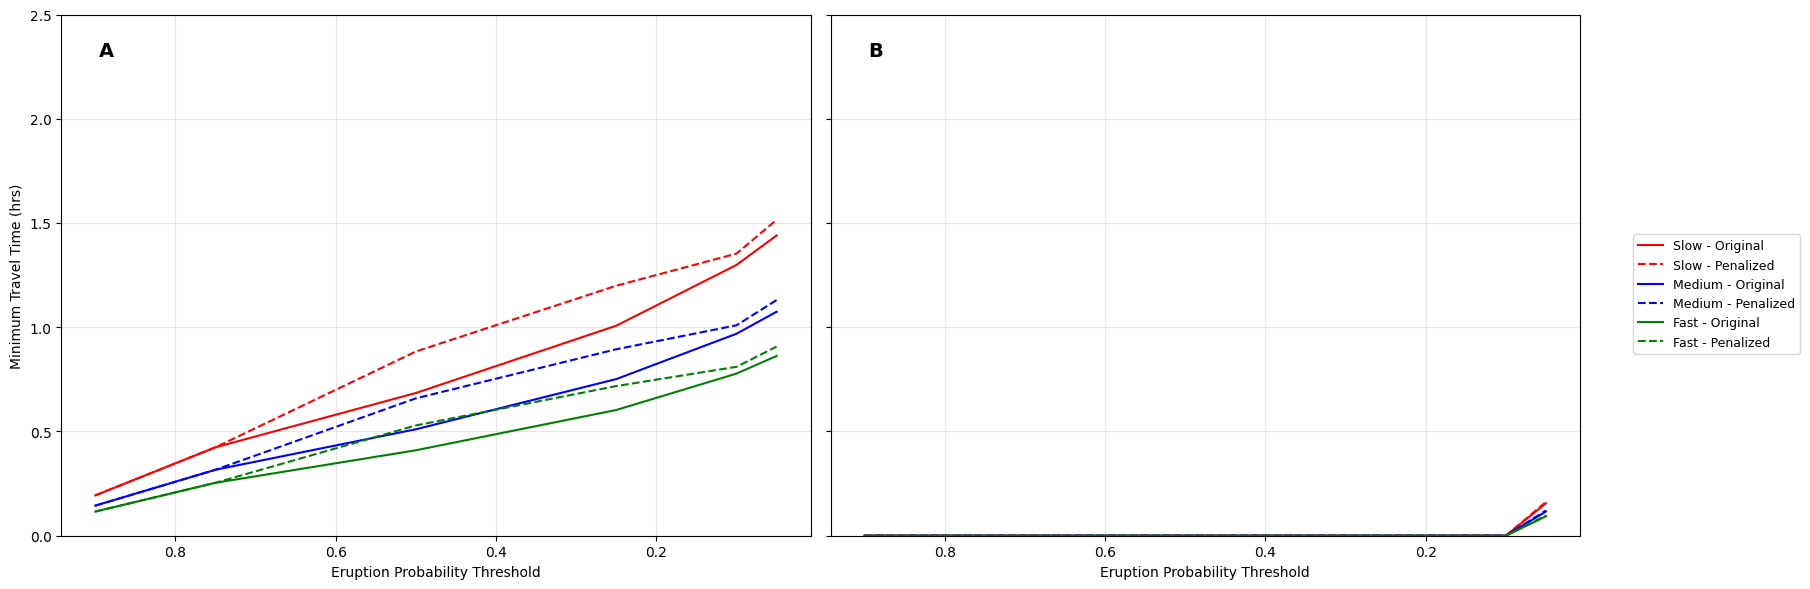

<Figure size 640x480 with 0 Axes>

In [16]:
# Step 3: Generate comparison plots
print("\n--- Generating Travel Time Comparison Plots ---")
comparison_plot = plot_travel_time_comparison(
    all_results, source_names, thresholds, walking_speeds, output_dir
)
plt.figure()  # Create a new figure for the next plot
plt.show()    # Display the current figure

# Step 7: Visualization - Cost Surface and Paths

## Explanation

This step generates **visual maps** displaying the **cost surface** (terrain difficulty) with **overlaid evacuation paths**.

---

### **1. `plot_cost_surface_with_paths` Function**
This function **creates maps** that visualize:
- The **cost surface** (difficulty of movement across terrain).
- The **optimal evacuation paths** for different **eruption probability thresholds**.

#### **Function Parameters:**
- **`dataset_info`** – Dictionary containing **dataset metadata**.
- **`evacuation_paths`** – Dictionary storing **calculated evacuation paths**.
- **`eruption_probability_path`** – Path to the **eruption probability raster**.
- **`hiking_path`** – Path to the **hiking trail shapefile**.
- **`selected_speed`** – **Walking speed** to visualize (**medium speed** is typically used).
- **`thresholds`** – List of **eruption probability thresholds**.
- **`output_dir`** – Directory where **plots** will be saved.
- **`vei_label`** – Label for the **Volcanic Explosivity Index** (e.g., **VEI4**).

#### **Function Output:**
- **Returns file paths** of the saved visualization plots.

---

### **2. Purpose of Visualization**
- Provides a **spatial understanding** of:
  - How **evacuation routes** interact with the **terrain**.
  - The relationship between **safe zones** and **hiking paths**.
- Helps decision-makers **assess** evacuation feasibility **visually**.

This step enhances **situational awareness**, ensuring better evacuation planning under different **eruption risk scenarios**.



--- Generating Cost Surface Plots with Evacuation Paths ---

Creating cost surface subplots with evacuation paths...


C:\Users\Mojan\Desktop\RA Volcano\Python Code\github\probability\visualization.py:282: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


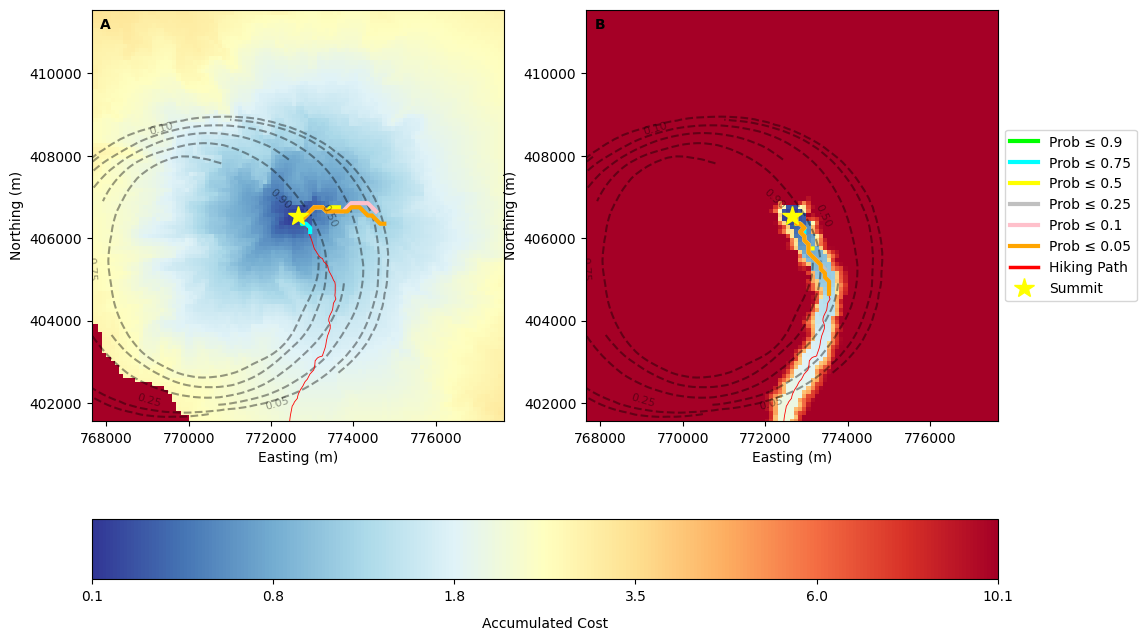

Cost surface visualization with evacuation paths saved to: C:\Users\Mojan\Desktop\RA Volcano\python_results\evacuation_paths_by_probability_threshold_VEI4_medium.png


<Figure size 640x480 with 0 Axes>

In [17]:
# Step 4: Generate cost surface plots with evacuation paths
print("\n--- Generating Cost Surface Plots with Evacuation Paths ---")
selected_speed = "medium"  # Use medium speed for visualization
path_plots = plot_cost_surface_with_paths(
    dataset_info, evacuation_paths, eruption_probability_path,
    hiking_path, selected_speed, thresholds, output_dir, vei_label="VEI4"
)
plt.figure()  # Create a new figure for the next plot
plt.show()    # Display the current figure


Using file paths:
Eruption probability VEI3: C:\Users\Mojan\Desktop\RA Volcano\projection\VEI3_Project11.tif
Eruption probability VEI4: C:\Users\Mojan\Desktop\RA Volcano\projection\VEI4_cor_proj1.tif
Eruption probability VEI5: C:\Users\Mojan\Desktop\RA Volcano\projection\VEI5_Project11.tif
Summit: C:\Users\Mojan\Desktop\RA Volcano\projection\summit_awu_correct_proj_final.shp
Hiking path: C:\Users\Mojan\Desktop\RA Volcano\projection\hikingpath_awu_buffer_correctproj_final.shp

--- Creating VEI Comparison Plot ---

Creating VEI comparison plot...
Raster CRS for VEI3: PROJCS["WGS_1984_UTM_Zone_51N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORI

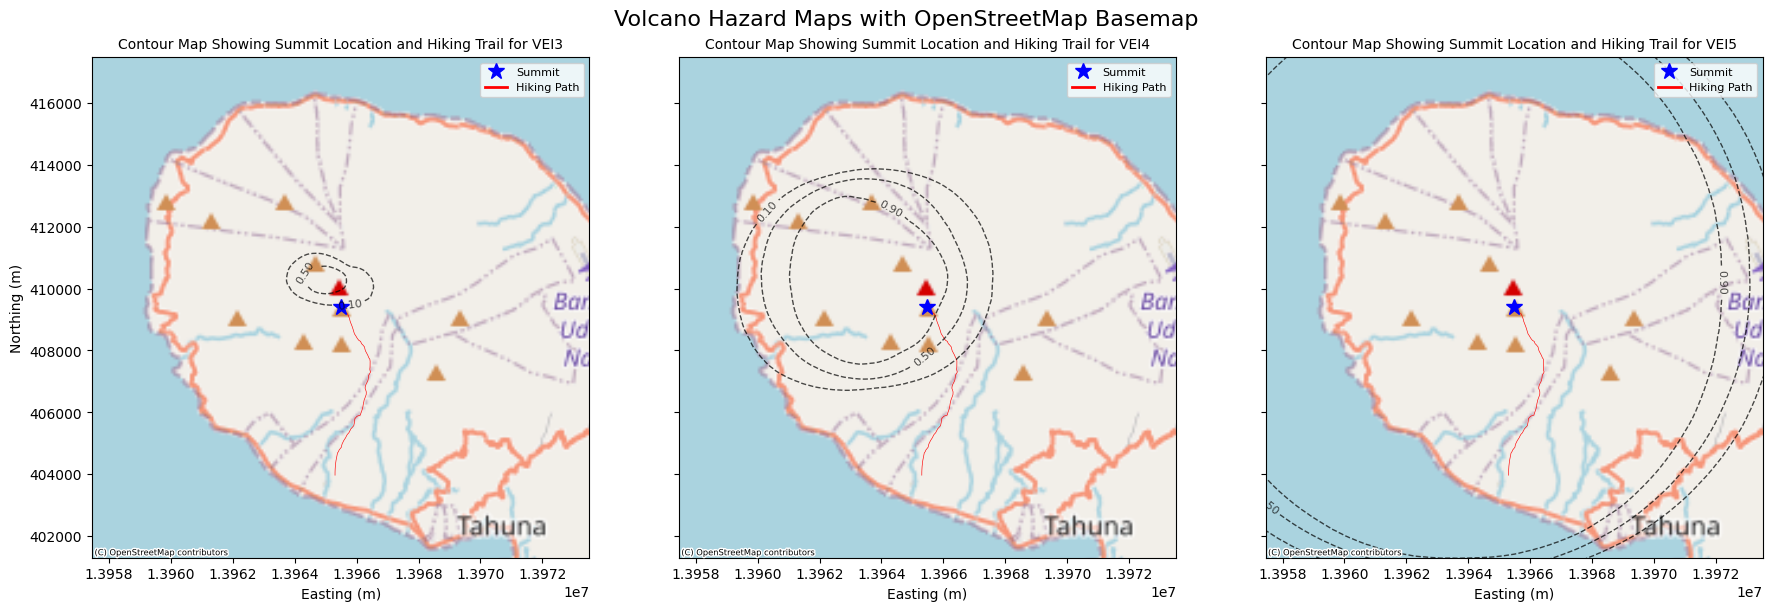

VEI comparison plot saved to: C:\Users\Mojan\Desktop\RA Volcano\python_results\vei_comparison_contour_maps.png

VEI comparison plot saved to: C:\Users\Mojan\Desktop\RA Volcano\python_results\vei_comparison_contour_maps.png


In [ ]:


# Import functions from your existing code
from data_utils import read_shapefile

def create_vei_comparison_plot(eruption_probability_paths, hiking_path, summit_path, output_dir):
    """
    Create a comparison plot of contour maps for different VEI levels side by side.
    
    Args:
        eruption_probability_paths (dict): Dictionary of VEI levels and their file paths
        hiking_path (str): Path to the hiking path shapefile
        summit_path (str): Path to the summit point shapefile
        output_dir (str): Directory to save the plot
        
    Returns:
        str: Path to the saved plot
    """
    print("\nCreating VEI comparison plot...")
    
    # Load hiking trail shapefile
    hiking_gdf = read_shapefile(hiking_path)
    
    # Load summit points
    summit_gdf = read_shapefile(summit_path)
    
    # Create figure with subplots for each VEI level - make them square and equally sized
    fig, axes = plt.subplots(1, len(eruption_probability_paths), figsize=(18, 6), 
                           sharey=True, sharex=True, constrained_layout=True)
    
    # If only one VEI level, convert axes to list
    if len(eruption_probability_paths) == 1:
        axes = [axes]
        
    # Make all subplots have equal aspect ratio (square)
    for ax in axes:
        ax.set_aspect('equal')
    
    # Define eruption probability thresholds - CRITICAL: Must be in ASCENDING order for matplotlib contour
    thresholds = [ 0.1,0.5, 0.9]
    
    # Define CRS for UTM Zone 51N and Web Mercator
    utm_crs = CRS.from_epsg(32651)  # WGS84 UTM Zone 51N
    web_mercator_crs = CRS.from_epsg(3857)  # Web Mercator
    
    # Create transformer from UTM to Web Mercator
    transformer = Transformer.from_crs(utm_crs, web_mercator_crs, always_xy=True)
    
    # Transform hiking_gdf to Web Mercator for basemap
    if hiking_gdf.crs is None:
        hiking_gdf.crs = utm_crs
    hiking_gdf_web_mercator = hiking_gdf.to_crs(web_mercator_crs)
    
    # Transform summit_gdf to Web Mercator for basemap
    if summit_gdf.crs is None:
        summit_gdf.crs = utm_crs
    summit_gdf_web_mercator = summit_gdf.to_crs(web_mercator_crs)
    
    # Process each VEI level
    for i, (vei, path) in enumerate(eruption_probability_paths.items()):
        ax = axes[i]
        
        # Load eruption probability raster
        with rasterio.open(path) as src:
            prob_array = src.read(1)
            transform = src.transform
            bounds = src.bounds
            
            # Get CRS information for the raster
            raster_crs = src.crs
            print(f"Raster CRS for {vei}: {raster_crs}")
            
            # Create coordinate grid in UTM
            x = np.linspace(bounds.left, bounds.right, prob_array.shape[1])
            y = np.linspace(bounds.bottom, bounds.top, prob_array.shape[0])
            X, Y = np.meshgrid(x, y)
            
            # Get summit coordinates in UTM
            summit_x = summit_gdf.geometry.x.values[0]
            summit_y = summit_gdf.geometry.y.values[0]
            
            # Set radius to 10km (10,000m) for all VEI levels for consistency
            radius = 8000
            
            # Create a bounding box for the area around the summit in UTM
            bbox_utm = box(summit_x - radius, summit_y - radius, 
                          summit_x + radius, summit_y + radius)
            
            # Create a GeoDataFrame from the bounding box in UTM
            bbox_gdf_utm = gpd.GeoDataFrame({'geometry': [bbox_utm]}, crs=utm_crs)
            
            # Convert the bounding box to Web Mercator
            bbox_gdf_web_mercator = bbox_gdf_utm.to_crs(web_mercator_crs)
            bbox_web_mercator = bbox_gdf_web_mercator.geometry.values[0]
            
            # Get Web Mercator bounding box coordinates
            wm_minx, wm_miny, wm_maxx, wm_maxy = bbox_web_mercator.bounds
            
            # Set up the axis for Web Mercator
            ax.set_xlim(wm_minx, wm_maxx)
            ax.set_ylim(wm_miny, wm_maxy)
            
            # Add OpenStreetMap basemap using contextily with specific provider and parameters
            try:
                ctx.add_basemap(
                    ax,
                    source=ctx.providers.OpenStreetMap.Mapnik,
                    zoom=11,  # Adjust zoom level for better detail
                    attribution_size=6  # Smaller attribution text
                )
                print(f"Successfully added OSM background for {vei}")
            except Exception as e:
                print(f"Warning: Could not add OpenStreetMap basemap for {vei}. Error: {e}")
                # Create a light blue background as fallback
                ax.imshow(np.ones((100, 100, 3)), 
                         extent=[wm_minx, wm_maxx, wm_miny, wm_maxy],
                         cmap='Blues', alpha=0.1, vmin=0, vmax=1)
            
            # Transform the contour data to Web Mercator
            X_web_mercator = np.zeros_like(X)
            Y_web_mercator = np.zeros_like(Y)
            
            for row in range(X.shape[0]):
                for col in range(X.shape[1]):
                    X_web_mercator[row, col], Y_web_mercator[row, col] = transformer.transform(X[row, col], Y[row, col])
            
            # Create contours for probability thresholds using transformed coordinates
            contours = ax.contour(X_web_mercator, Y_web_mercator, prob_array, levels=thresholds,
                                 colors='black', linestyles='--', alpha=0.7,
                                 linewidths=1.0)
            ax.clabel(contours, inline=True, fmt='%1.2f', fontsize=8)
            
            # Plot hiking trail (already in Web Mercator)
            hiking_gdf_web_mercator.plot(ax=ax, color='red', linewidth=2.0)
            
            # Plot summit with star marker (in Web Mercator)
            summit_x_wm = summit_gdf_web_mercator.geometry.x.values[0]
            summit_y_wm = summit_gdf_web_mercator.geometry.y.values[0]
            ax.plot(summit_x_wm, summit_y_wm, '*', color='blue', markersize=12)
            
            # Set title
            ax.set_title(f'Contour Map Showing Summit Location and Hiking Trail for {vei}', fontsize=10)
            
            # Add axis labels
            ax.set_xlabel('Easting (m)')
            if i == 0:  # Only add y-label for the first subplot
                ax.set_ylabel('Northing (m)')
            
            # Add legend for each subplot
            ax.plot([], [], '*', color='blue', markersize=12, label='Summit')
            ax.plot([], [], '-', color='red', linewidth=2.0, label='Hiking Path')
            ax.legend(loc='upper right', fontsize=8)
    
    # Add a common title to the figure
    fig.suptitle('Volcano Hazard Maps with OpenStreetMap Basemap', fontsize=16)
    
    # Don't use tight_layout with constrained_layout=True
    # plt.tight_layout()
    
    # Save the plot
    output_path = os.path.join(output_dir, 'vei_comparison_contour_maps.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"VEI comparison plot saved to: {output_path}")
    return output_path

# Main execution
if __name__ == "__main__":
    # Define paths
    data_folder = r'C:\Users\Mojan\Desktop\RA Volcano\python_results'
    output_dir = data_folder
    
    # Define eruption probability paths for different VEI levels
    eruption_probability_paths = {
        'VEI3': r"C:\Users\Mojan\Desktop\RA Volcano\projection\VEI3_Project11.tif",
        'VEI4': r"C:\Users\Mojan\Desktop\RA Volcano\projection\VEI4_cor_proj1.tif",
        'VEI5': r"C:\Users\Mojan\Desktop\RA Volcano\projection\VEI5_Project11.tif"
    }
    
    # Define paths for other required files
    summit_path = r"C:\Users\Mojan\Desktop\RA Volcano\projection\summit_awu_correct_proj_final.shp"
    hiking_path = r'C:\Users\Mojan\Desktop\RA Volcano\projection\hikingpath_awu_buffer_correctproj_final.shp'
    
    # Print file paths to confirm
    print("\nUsing file paths:")
    for vei, path in eruption_probability_paths.items():
        print(f"Eruption probability {vei}: {path}")
    print(f"Summit: {summit_path}")
    print(f"Hiking path: {hiking_path}")
    
    # Create the comparison plot
    print("\n--- Creating VEI Comparison Plot ---")
    comparison_plot = create_vei_comparison_plot(
        eruption_probability_paths, hiking_path, summit_path, output_dir
    )
    print(f"\nVEI comparison plot saved to: {comparison_plot}")